#Name: Sharmin Akhter
### ID. 201891112
### Title: Comparative Analysis of Pretrained Convolutional Neural Networks for Image Classification on the Oxford Flowers102 Dataset

#Import libraries

In [ ]:
!pip install -q tqdm==4.28.1
!pip install -q -U "tensorflow-gpu==2.0.0b1"
!pip install -q -U tensorflow_datasets
!pip install -q -U tensorflow_hub
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.5.1 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
prophet 1.1.2 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is incompatible.
panel 0.14.4 requires tqdm>=4.48.0, but you have tqdm 4.28.1 which is incompatible.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0b1 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution foun

# Dataset Information
The Oxford Flowers102 dataset is a consistent of 102 flower categories commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set. The training set and validation set each consist of 10 images per class (totalling 1020 images each). The test set consists of the remaining 6149 images (minimum 20 per class).

#Attributions
- https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
(data source)
- https://keras.io/examples/generative/ddim/
(it helps me to load data for denseNet, ResNet, VGG)
- https://www.kaggle.com/code/dtosidis/flower-classifier-tensorflow
- ChatGPT

#Load Oxford flowers 102 dataset

In [ ]:
# Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
dataset_info
# Create a training set, a validation set and a test set.
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


#Explore the dataset

In [ ]:
# Get the number of examples in each set from the dataset info.
num_training_examples = 0
num_validation_examples = 0
num_test_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

for example in test_set:
  num_test_examples += 1

print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {}'.format(num_validation_examples))
print('Total Number of Test Images: {} \n'.format(num_test_examples))

#Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
print('Total Number of Classes: {}'.format(num_classes))

Total Number of Training Images: 1020
Total Number of Validation Images: 1020
Total Number of Test Images: 6149 

Total Number of Classes: 102


#Print the Shape

In [ ]:
# The images in the Flowers dataset are not all the same size.
for i, example in enumerate(training_set.take(3)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (500, 667, 3) label: 72
Image 2 shape: (500, 666, 3) label: 84
Image 3 shape: (670, 500, 3) label: 70


#Plot image label

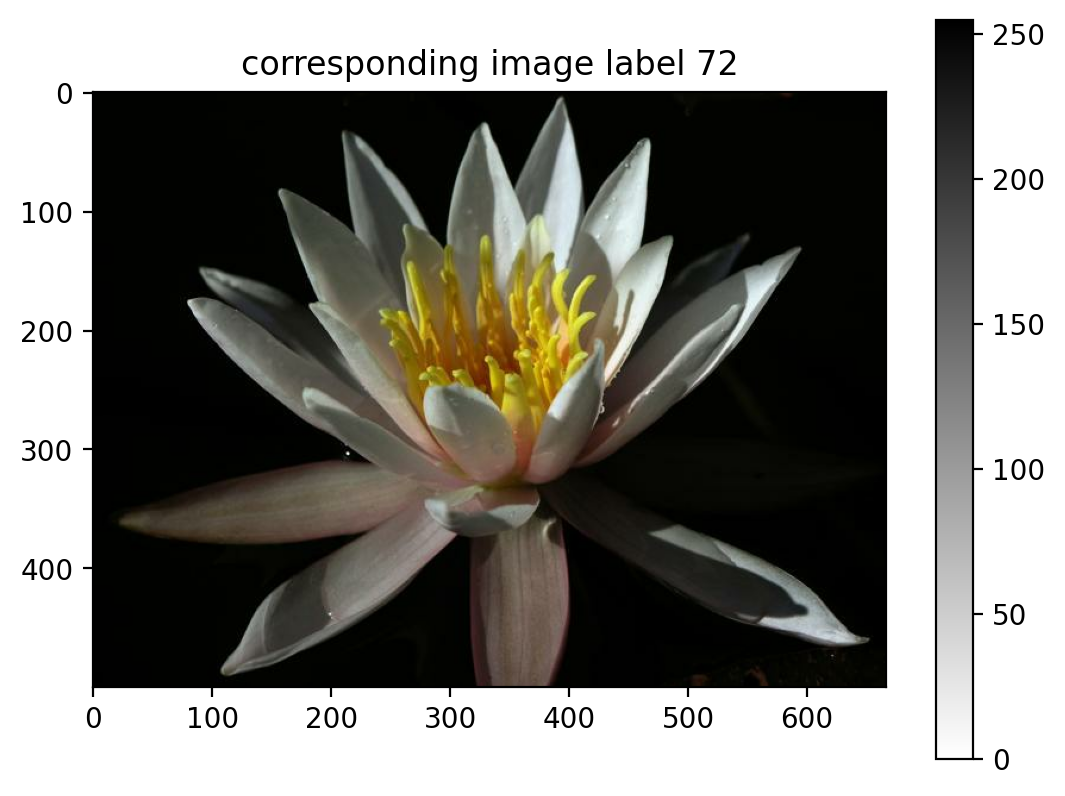

In [ ]:
 #the plot to the corresponding image label. 
for image, label in training_set.take(1):
  break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('corresponding image label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

#Pipeline for train, test, validation

In [ ]:
#Create a pipeline for each set.
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

test_batches = test_set.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#Build Model

In [ ]:
#Build and train network.
from tensorflow.keras import layers
# Create a Feature Extractor
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))
# Freeze the Pre-Trained Model
feature_extractor.trainable = False
# Attach a classification head
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


#Compile the Model

In [ ]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 20

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/20
32/32 [==============================] - 125s 4s/step - loss: 4.1424 - accuracy: 0.1373 - val_loss: 3.0242 - val_accuracy: 0.4137
Epoch 2/20
32/32 [==============================] - 77s 2s/step - loss: 2.0113 - accuracy: 0.6980 - val_loss: 1.9779 - val_accuracy: 0.6480
Epoch 3/20
32/32 [==============================] - 79s 3s/step - loss: 1.0631 - accuracy: 0.8990 - val_loss: 1.5197 - val_accuracy: 0.7275
Epoch 4/20
32/32 [==============================] - 78s 2s/step - loss: 0.6432 - accuracy: 0.9647 - val_loss: 1.2935 - val_accuracy: 0.7755
Epoch 5/20
32/32 [==============================] - 121s 4s/step - loss: 0.4317 - accuracy: 0.9843 - val_loss: 1.1547 - val_accuracy: 0.7873
Epoch 6/20
32/32 [==============================] - 81s 3s/step - loss: 0.3076 - accuracy: 0.9941 - val_loss: 1.0675 - val_accuracy: 0.7951
Epoch 7/20
32/32 [==============================] - 78s 2s/step - loss: 0.2301 - accuracy: 0.9961 - val_loss: 1.0078 - val_accuracy: 0.8010
Epoch 8/20
32/32 [

#Plot Loss function and Test Accuracy

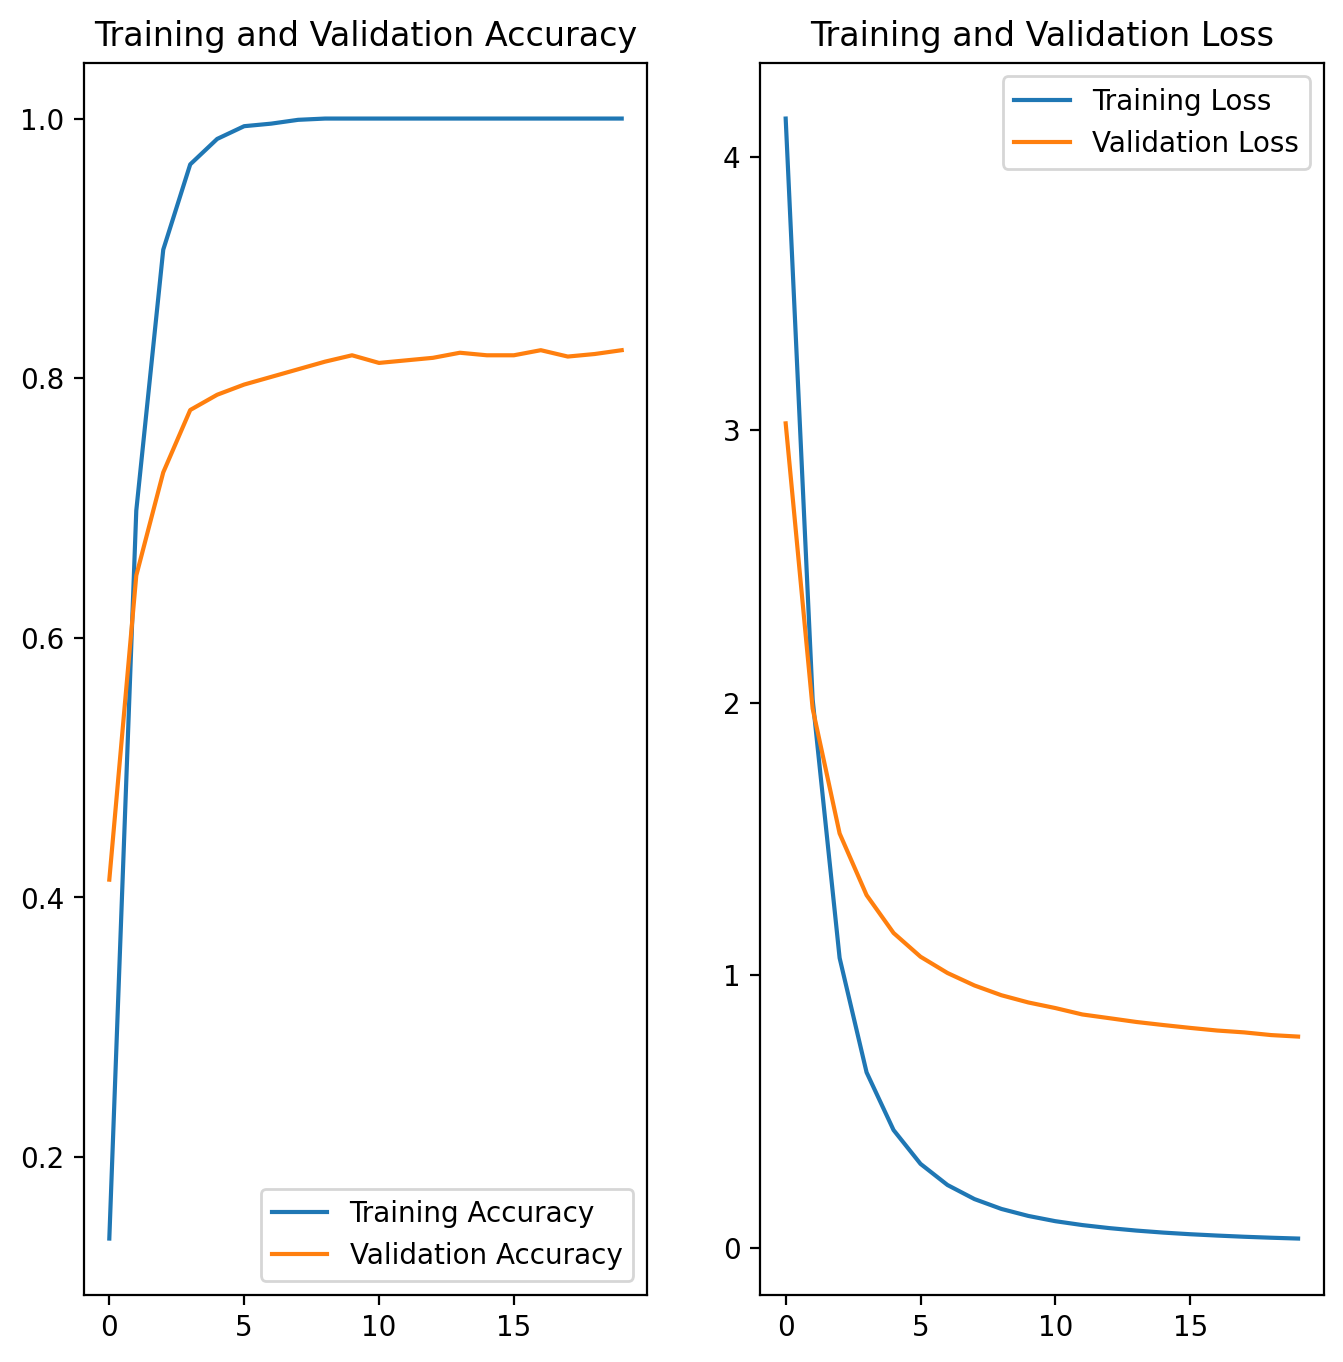

In [ ]:
#Plot the loss and accuracy values achieved during training for the training and validation set.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Print the loss and accuracy values achieved on the entire test set.
results = model.evaluate(test_batches)
print('test loss, test acc:', results)

193/193 [==============================] - 260s 1s/step - loss: 0.8978 - accuracy: 0.7853
test loss, test acc: [0.897802472114563, 0.7853309512138367]


In [ ]:
loss, accuracy = model.evaluate(test_batches, batch_size=32)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

193/193 [==============================] - 236s 1s/step - loss: 0.8978 - accuracy: 0.7853
Test Loss: 0.897802472114563
Test Accuracy: 0.7853309512138367


# The test accuracy is 78%